In [1]:
#@title Setup

import os
import glob
import json
import random
import shutil
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import wfdb

lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
hz = 500
start_time = 0
time = 10
start_length = int(start_time * hz)
sample_length = int(time * hz)
end_time = start_time + time
t = np.arange(start_time, end_time, 1 / hz)

def draw_ecg(ecg: np.ndarray, lead=1):
    """
    Draws a single ECG lead
    :param ecg: ECG data
    :param lead: Lead number
    :return: None
    """
    plt.plot(
        t,
        ecg[lead][start_length: start_length + sample_length],
        linewidth=2,
        color="k",
        alpha=1.0,
        label=lead_names[lead]
    )
    minimum = min(ecg[lead])
    maximum = max(ecg[lead])
    ylims_candidates = [-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0 , 1.5, 2.0, 2.5]

    ylims = (
        max([x for x in ylims_candidates if x <= minimum]),
        min([x for x in ylims_candidates if x >= maximum]),
    )
    plt.vlines(np.arange(start_time, end_time, 0.2), ylims[0], ylims[1], colors="r", alpha=1.0)
    plt.vlines(np.arange(start_time, end_time, 0.04), ylims[0], ylims[1], colors="r", alpha=0.3)
    plt.hlines(np.arange(ylims[0], ylims[1], 0.5), start_time, end_time, colors="r", alpha=1.0)
    plt.hlines(np.arange(ylims[0], ylims[1], 0.1), start_time, end_time, colors="r", alpha=0.3)

    plt.xticks(np.arange(start_time, end_time + 1, 1.0))
    plt.margins(0.0)
    plt.show()

def draw_ecgs(ecgs: list, lead=1):
    """
    Draws multiple ECG leads
    :param ecgs: ECG data
    :param lead: Lead number
    :return: None
    """
    for i, ecg in enumerate(ecgs):
        plt.rcParams["figure.figsize"] = (25, 1.5 * len(ecgs))
        plt.subplot(len(ecgs), 1, i + 1)
        draw_ecg(ecg, lead)

def visualize_sample(sample_data, lead):
    ecgs = []
    for i, ecg_path in enumerate(sample_data["ecg_path"]):
        if not os.path.exists(ecg_path + ".dat"):
            download_ptbxl(sample_data["ecg_id"][i])

        ecg, _ = wfdb.rdsamp(ecg_path)
        ecgs.append(ecg.T)

    draw_ecgs(ecgs, lead)
    print(f"Sample ID: {sample_data['sample_id']}")
    print(f"Question: {sample_data['question']}")
    print(f"Answer: {sample_data['answer']}")

def get_ptbxl_data_path(ecg_id):
    return os.path.join(
        f"{int(ecg_id / 1000) * 1000 :05d}",
        f"{ecg_id:05d}_hr"
    )

def download_ptbxl(ecg_id):
    ptbxl_data_path = get_ptbxl_data_path(ecg_id)
    !wget -r -N -c np https://physionet.org/files/ptb-xl/1.0.3/records500/{ptbxl_data_path}.hea -P ptbxl &> /dev/null
    shutil.move(
        os.path.join("ptbxl", f"physionet.org/files/ptb-xl/1.0.3/records500/{ptbxl_data_path}.hea"),
        os.path.join("ptbxl")
    )

    !wget -r -N -c np https://physionet.org/files/ptb-xl/1.0.3/records500/{ptbxl_data_path}.dat -P ptbxl &> /dev/null
    shutil.move(
        os.path.join("ptbxl", f"physionet.org/files/ptb-xl/1.0.3/records500/{ptbxl_data_path}.dat"),
        os.path.join("ptbxl")
    )
    shutil.rmtree(os.path.join("ptbxl", "physionet.org"))

In [ ]:
#@title Setup up the ECG-QA dataset

#@markdown 1. Get the ECG-QA dataset from github

#@markdown 2. Map each ecg_id with its corresponding PTB-XL ECG path

#@markdown 3. Print random sample

## get the dataset
## map to PTB-XL ECG path
ptbxl_path = "ptbxl"
if not os.path.exists(ptbxl_path):
    os.mkdir(ptbxl_path)

for fname in glob.iglob("ecg-qa/ecgqa/ptbxl/paraphrased/**/*.json"):
    split = fname.split("/")[-2]
    basename = os.path.basename(fname)
    if not os.path.exists("output"):
        os.makedirs("output")

    with open(fname, "r") as f:
        data = json.load(f)

    for i, sample in enumerate(data):
        sample["ecg_path"] = []
        for ecg_id in sample["ecg_id"]:
            sample["ecg_path"].append(f"ptbxl/{ecg_id:05d}_hr")

    if not os.path.exists(os.path.join("output", split)):
        os.makedirs(os.path.join("output", split))
    with open(os.path.join("output", split, basename), "w") as f:
        json.dump(data, f, indent=4)

with open("ecg-qa/output/ptbxl/00000.json", "r") as f:
    sample_data = json.load(f)
select = random.randint(0, 9999)
pprint(sample_data[select], sort_dicts=False)

del sample_data

FileNotFoundError: [Errno 2] No such file or directory: 'ecg-qa/output/ptbxl/000000.json'

# Visualize

In [3]:
#@markdown
split = "train" #@param ["train", "valid", "test"]

data = []
for fname in sorted(glob.glob(os.path.join("output", split, "*.json"))):
    with open(fname, "r") as f:
        data.extend(json.load(f))

print(f"loaded {len(data)} {split} samples!")

loaded 267539 train samples!


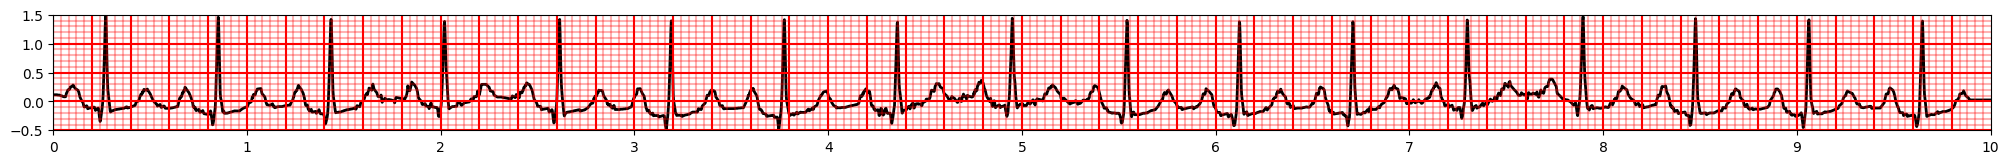

Sample ID: 152585
Question: What ECG values are present within the normal range?
Answer: ['qrs duration', 'qt corrected', 'p duration', 'pr interval']


In [4]:
#@markdown ## Visualize random ECG-QA sample

lead = "II" #@param ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = lead_names.index(lead)
sample_id = random.randint(0, len(data) - 1)

visualize_sample(data[sample_id], lead)

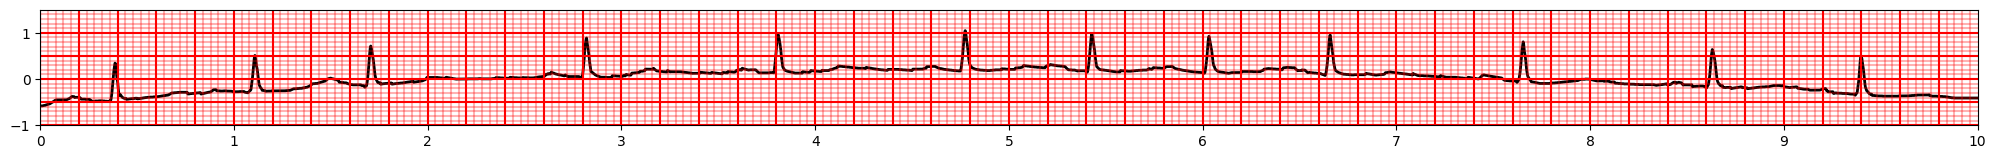

Sample ID: 0
Question: Is there evidence of non-diagnostic t abnormalities on this ECG?
Answer: ['yes']


In [ ]:
#@markdown ## Visualize a specific ECG-QA sample

sample_id = 0 #@param {type: "integer"}

lead = "II" #@param ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = lead_names.index(lead)

visualize_sample(data[sample_id], lead)

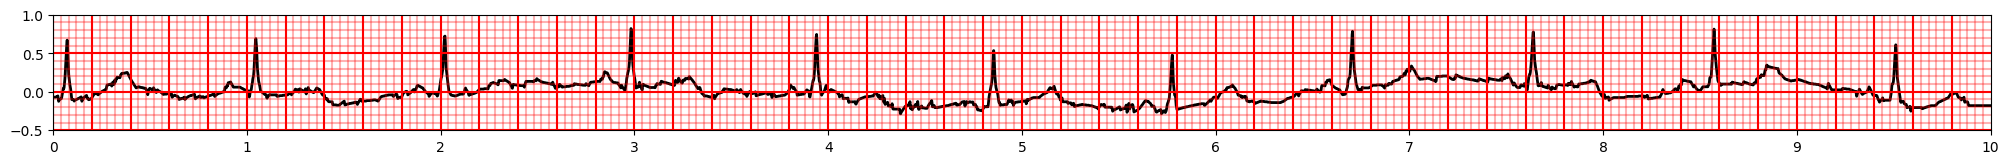

#0
Sample ID: 4316
Template ID: 1
Question ID: 12
Question: Are there any manifestations of ischemic in anterolateral leads on this ECG?
Answer: ['no']

#1
Sample ID: 5021
Template ID: 1
Question ID: 14
Question: Can the presence of complete left bundle branch block be identified from this ECG?
Answer: ['no']

#2
Sample ID: 12827
Template ID: 1
Question ID: 46
Question: Can the presence of low qrs voltages in the frontal and horizontal leads be identified from this ECG?
Answer: ['no']

#3
Sample ID: 18558
Template ID: 4
Question ID: 96
Question: What is the diagnostic symptom indicated by this ECG, specifically right atrial overload/enlargement or non-diagnostic t abnormalities, including any uncertain symptoms?
Answer: ['none']

#4
Sample ID: 30059
Template ID: 4
Question ID: 429
Question: What diagnostic symptom is being manifested in this ECG, ischemic in anterolateral leads or myocardial infarction in anterolateral leads, even though there are unclear symptoms?
Answer: ['none']

#5

In [ ]:
#@markdown ## Visualize all ECG-QA samples based on a specific ECG ID

#@markdown Note that we visualize only the *Single* type questions currently.

ecg_id = 3 #@param {type: "integer"}

lead = "II" #@param ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = lead_names.index(lead)

sample_data = [x for x in data if x["ecg_id"] == [ecg_id]]

if len(sample_data) == 0:
    print(f"Cannot find ecg_id == {ecg_id}")
else:
    ecg_path = sample_data[0]["ecg_path"][0]
    if not os.path.exists(ecg_path + ".dat"):
        download_ptbxl(sample_data[0]["ecg_id"][0])

    ecg, _ = wfdb.rdsamp(ecg_path)

    draw_ecgs([ecg.T], lead)

    for i, sample in enumerate(sample_data):
        print(f"#{i}")
        print(f"Sample ID: {sample['sample_id']}")
        print(f"Template ID: {sample['template_id']}")
        print(f"Question ID: {sample['question_id']}")
        print(f"Question: {sample['question']}")
        print(f"Answer: {sample['answer']}")
        print()

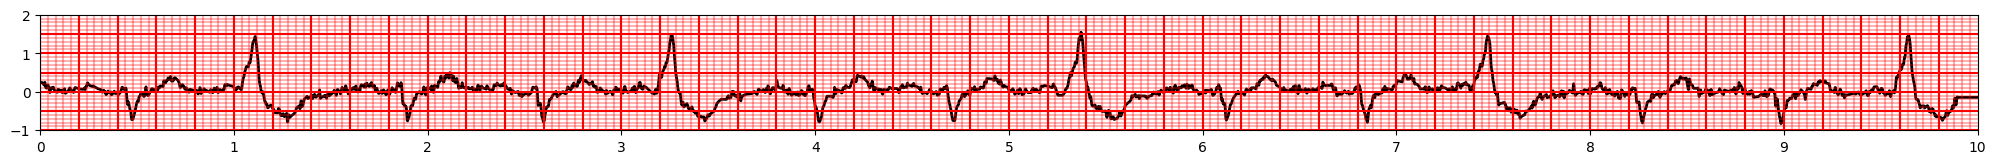

Sample ID: 8438
Question: Does this ECG reveal any signs of ischemic in lateral leads?
Answer: ['no']


In [ ]:
#@markdown ## Visualize random ECG-QA sample based on a specific template ID

#@markdown template_id should be between 1 and 70
template_id = 1 #@param {type: "integer"}

lead = "II" #@param ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = lead_names.index(lead)

sample_data = [x for x in data if x["template_id"] == template_id]
if len(sample_data) == 0:
    print(f"Cannot find template_id == {template_id}")
else:
    sample_id = random.randint(0, len(sample_data) - 1)

    visualize_sample(sample_data[sample_id], lead)

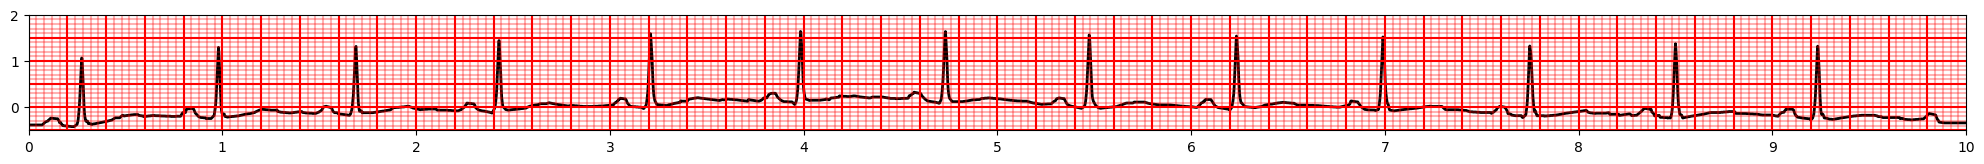

Sample ID: 48
Question: Does this ECG reveal any signs of non-diagnostic t abnormalities?
Answer: ['yes']


In [ ]:
#@markdown ## Visualize random ECG-QA sample based on a specific question ID

question_id = 0 #@param {type: "integer"}

lead = "II" #@param ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead = lead_names.index(lead)

sample_data = [x for x in data if x["question_id"] == question_id]
if len(sample_data) == 0:
    print(f"Cannot find question_id == {question_id}")
else:
    sample_id = random.randint(0, len(sample_data) - 1)

    visualize_sample(sample_data[sample_id], lead)